# Earnings Regression — Repro Notebook

This notebook reproduces the analysis performed by `scripts/run_earnings_analysis.py`. It loads `Data/earnings_regression_panel.csv`, computes mean Surprise and CAR by regime, creates the same figures, fits the same OLS model, and saves outputs under `Data/`. Each code cell includes a short explanation of the step.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from IPython.display import Image, display
sns.set(style='whitegrid')
%matplotlib inline

## Load prepared panel
The panel was produced by the preparation notebook and saved to `Data/earnings_regression_panel.csv`.

In [2]:
panel = pd.read_csv('Data/earnings_regression_panel.csv', parse_dates=['Earnings Date'])
print('panel shape:', panel.shape)
panel.head()

panel shape: (248, 7)


,Ticker,Earnings Date,Surprise,CAR,Regime,VIX,Δ10Y
0,GOOGL,2005-04-21,0.0095,0.000635,0,14.41,0.035971
1,NVDA,2005-05-12,0.0040,0.026393,0,16.12,0.027027
2,AAPL,2005-07-13,0.0000,0.001773,0,10.84,-0.047945
3,GOOGL,2005-07-21,0.0035,0.006394,0,10.97,-0.009259
4,NVDA,2005-08-11,0.0000,0.002138,0,12.42,0.033493


## Cleaning and type coercion
Coerce numeric columns, rename `Δ10Y` to `D10Y` for convenience, and drop rows missing `Surprise` or `CAR`.

In [28]:
df = panel.copy()
if 'Δ10Y' in df.columns:
    df = df.rename(columns={'Δ10Y':'D10Y'})
for c in ['Surprise','CAR','VIX','D10Y']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['Surprise','CAR'])
print('cleaned shape:', df.shape)
df.head()

cleaned shape: (248, 7)


,Ticker,Earnings Date,Surprise,CAR,Regime,VIX,D10Y
0,GOOGL,2005-04-21,0.0095,0.000635,0,14.41,0.035971
1,NVDA,2005-05-12,0.0040,0.026393,0,16.12,0.027027
2,AAPL,2005-07-13,0.0000,0.001773,0,10.84,-0.047945
3,GOOGL,2005-07-21,0.0035,0.006394,0,10.97,-0.009259
4,NVDA,2005-08-11,0.0000,0.002138,0,12.42,0.033493


## Means by Regime
Compute mean Surprise and CAR by `Regime` (if present) and save results.

In [5]:
if 'Regime' in df.columns:
    means = df.groupby('Regime')[['Surprise','CAR']].mean().reset_index()
    print('Means by Regime:\n', means)  # Fixed the string by using \n instead of a literal line break
    means.to_csv('Data/means_by_regime.csv', index=False)
else:
    print('No Regime column found')

Means by Regime:
    Regime  Surprise       CAR
0       0  0.032896  0.002641
1       1  0.007250 -0.000911
2       2  0.054710 -0.001356


## Visualisations
Create boxplots of Surprise and CAR by regime and a scatter Surprise vs CAR; display them inline and save to `Data/`.

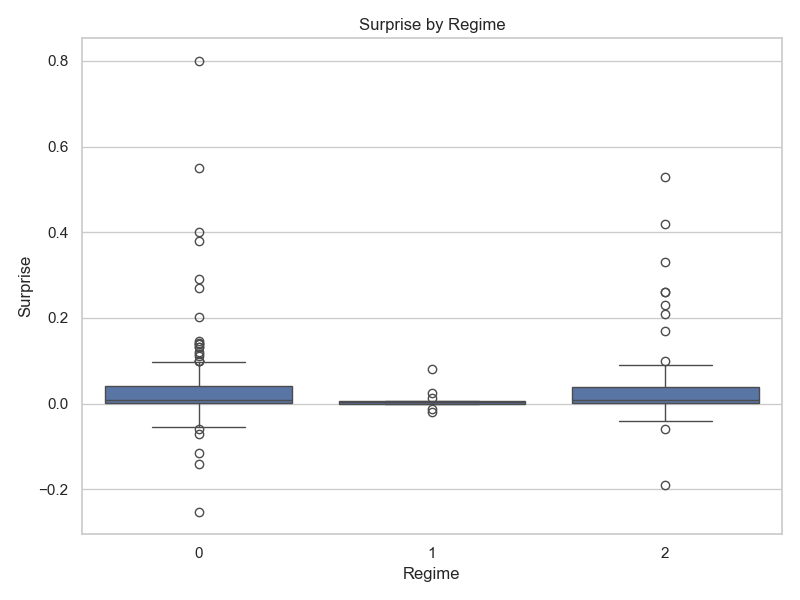

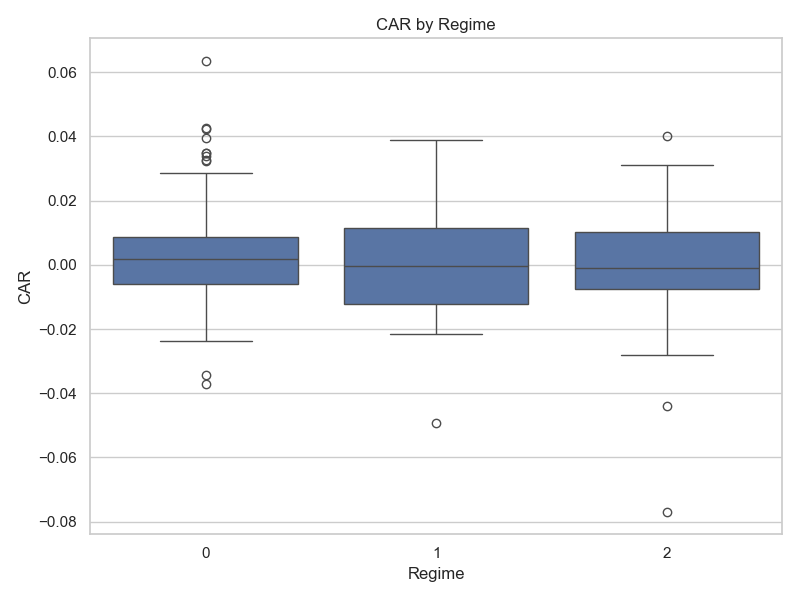

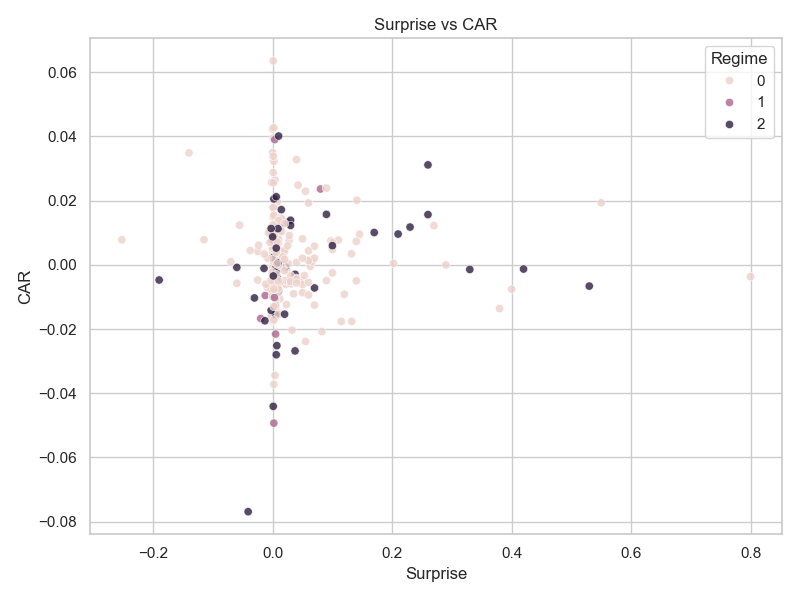

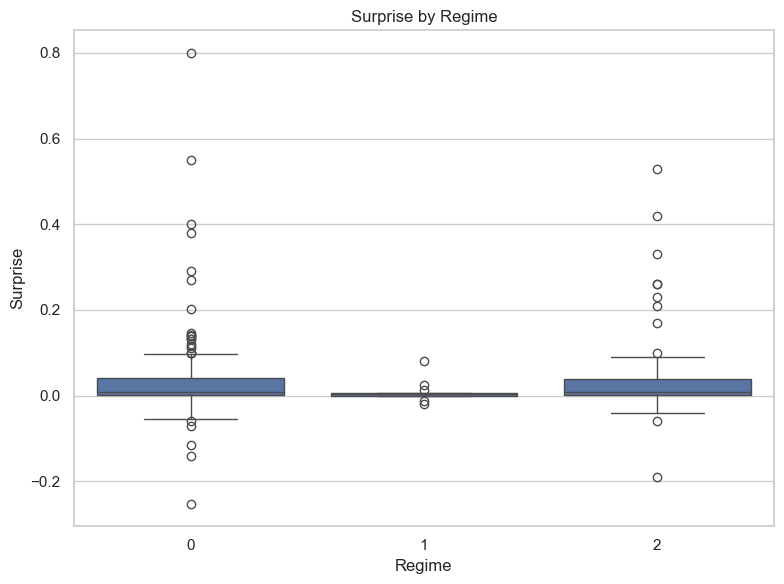

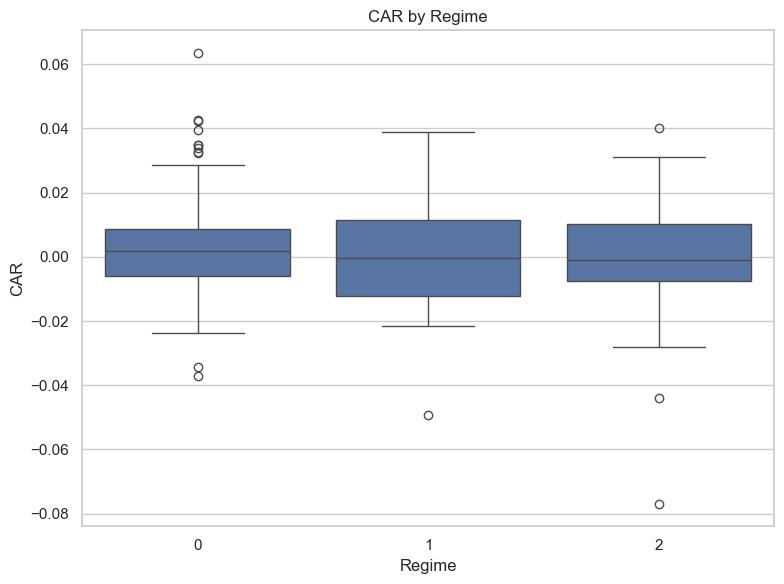

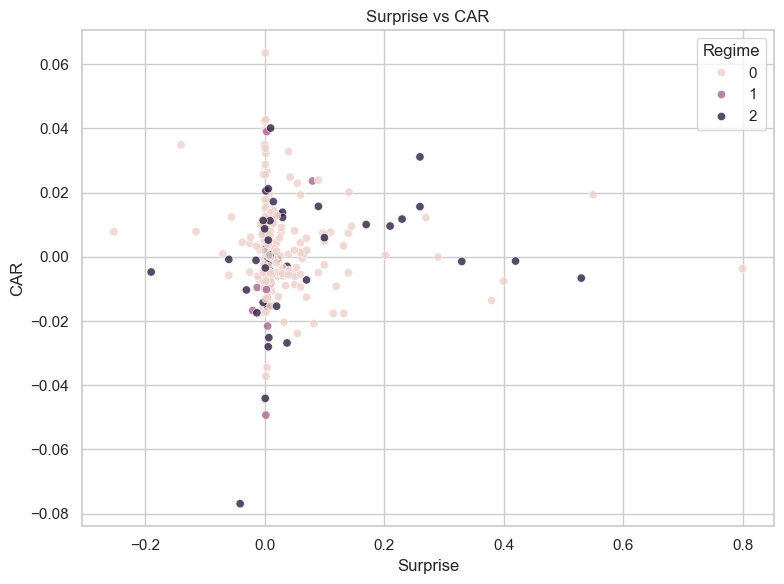

In [6]:
# Boxplots saved as PNGs
if 'Regime' in df.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Regime', y='Surprise', data=df)
    plt.title('Surprise by Regime')
    plt.tight_layout()
    plt.savefig('Data/fig_surprise_box.png')
    display(Image('Data/fig_surprise_box.png'))
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Regime', y='CAR', data=df)
    plt.title('CAR by Regime')
    plt.tight_layout()
    plt.savefig('Data/fig_car_box.png')
    display(Image('Data/fig_car_box.png'))
else:
    print('No Regime column available for boxplots')
# Scatter Surprise vs CAR
plt.figure(figsize=(8,6))
if 'Regime' in df.columns:
    sns.scatterplot(x='Surprise', y='CAR', hue='Regime', data=df, alpha=0.8)
else:
    sns.scatterplot(x='Surprise', y='CAR', data=df, alpha=0.8)
plt.title('Surprise vs CAR')
plt.tight_layout()
plt.savefig('Data/fig_scatter.png')
display(Image('Data/fig_scatter.png'))

## Regression
Fit the same model used in the script: `CAR ~ Surprise + C(Regime)` (terms are included only if the columns exist). Save the summary to `Data/regression_summary.txt`.

In [14]:
import statsmodels.formula.api as smf

# Clean interaction-only specification
formula = "CAR ~ Surprise * C(Regime)"

print("Formula:", formula)

model = smf.ols(
    formula=formula,
    data=df
).fit(cov_type="HC3")   # robust SEs

print(model.summary())

Formula: CAR ~ Surprise * C(Regime)
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.508
Date:                Sun, 15 Feb 2026   Prob (F-statistic):              0.188
Time:                        13:54:22   Log-Likelihood:                 688.34
No. Observations:                 248   AIC:                            -1365.
Df Residuals:                     242   BIC:                            -1344.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

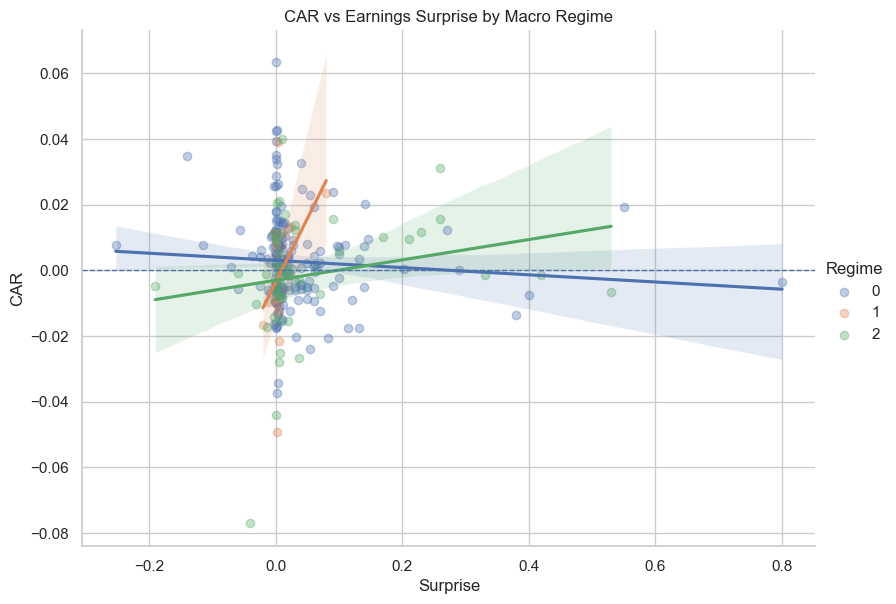

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=df,
    x="Surprise",
    y="CAR",
    hue="Regime",
    height=6,
    aspect=1.4,
    scatter_kws={"alpha": 0.35},
    ci=95
)

plt.title("CAR vs Earnings Surprise by Macro Regime")
plt.axhline(0, linestyle="--", linewidth=1)
plt.show()


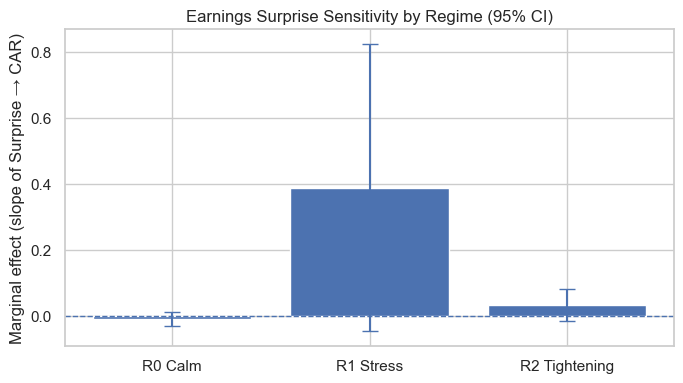

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_marginal_surprise_slopes(model, regime_labels=None):
    """
    Plots the marginal effect (slope) of Surprise on CAR for each regime with 95% CI.
    Works for formula: CAR ~ Surprise * C(Regime) (R0 baseline).
    """

    params = model.params
    cov = model.cov_params()

    # names depend on how Regime is encoded; these match your output
    bS = params["Surprise"]
    bS_R1 = params.get("Surprise:C(Regime)[T.1]", 0.0)
    bS_R2 = params.get("Surprise:C(Regime)[T.2]", 0.0)

    # implied slopes
    slopes = {
        "R0": bS,
        "R1": bS + bS_R1,
        "R2": bS + bS_R2,
    }

    # standard errors for linear combos using Var(a'b) = a'Cov a
    # R0 slope = [Surprise]
    var_R0 = cov.loc["Surprise", "Surprise"]

    # R1 slope = Surprise + Surprise:Regime1
    var_R1 = (cov.loc["Surprise", "Surprise"]
              + cov.loc["Surprise:C(Regime)[T.1]", "Surprise:C(Regime)[T.1]"]
              + 2 * cov.loc["Surprise", "Surprise:C(Regime)[T.1]"])

    # R2 slope = Surprise + Surprise:Regime2
    var_R2 = (cov.loc["Surprise", "Surprise"]
              + cov.loc["Surprise:C(Regime)[T.2]", "Surprise:C(Regime)[T.2]"]
              + 2 * cov.loc["Surprise", "Surprise:C(Regime)[T.2]"])

    ses = {"R0": np.sqrt(var_R0), "R1": np.sqrt(var_R1), "R2": np.sqrt(var_R2)}

    # 95% CI
    z = 1.96
    ci_low = {k: slopes[k] - z * ses[k] for k in slopes}
    ci_high = {k: slopes[k] + z * ses[k] for k in slopes}

    labels = ["R0", "R1", "R2"]
    if regime_labels:
        # allow replacing tick labels with your descriptions
        labels_display = [regime_labels.get(k, k) for k in labels]
    else:
        labels_display = labels

    y = [slopes[k] for k in labels]
    yerr = [[y[i] - ci_low[labels[i]] for i in range(3)],
            [ci_high[labels[i]] - y[i] for i in range(3)]]

    plt.figure(figsize=(7, 4))
    plt.bar(labels_display, y)
    plt.errorbar(labels_display, y, yerr=yerr, fmt="none", capsize=6)
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.ylabel("Marginal effect (slope of Surprise → CAR)")
    plt.title("Earnings Surprise Sensitivity by Regime (95% CI)")
    plt.tight_layout()
    plt.show()

# Example labels (optional)
regime_labels = {
    "R0": "R0 Calm",
    "R1": "R1 Stress",
    "R2": "R2 Tightening"
}

plot_marginal_surprise_slopes(model, regime_labels=regime_labels)


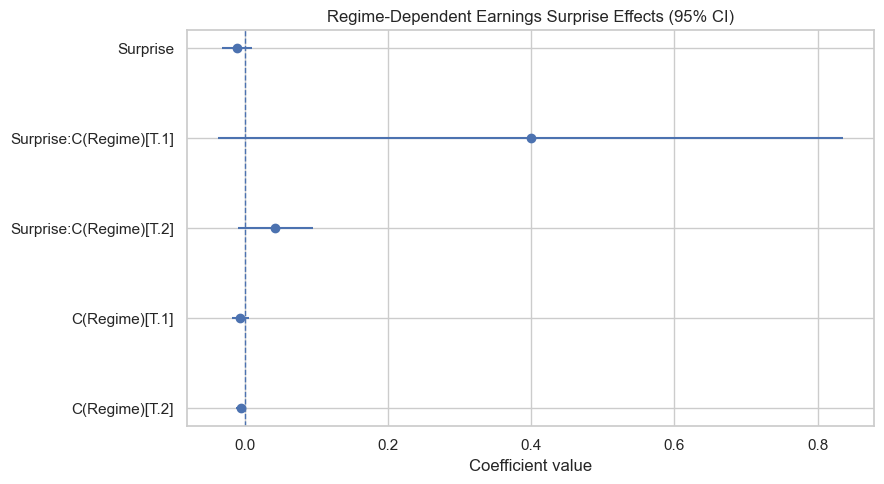

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def coef_plot(model, keep=None, title="Regression Coefficients (95% CI)"):
    """
    Horizontal coefficient plot with 95% CI.
    keep: optional list of coefficient names to include (in order).
    """
    params = model.params
    se = model.bse

    coef_df = pd.DataFrame({
        "coef": params,
        "se": se
    })
    coef_df["low"] = coef_df["coef"] - 1.96 * coef_df["se"]
    coef_df["high"] = coef_df["coef"] + 1.96 * coef_df["se"]

    # optional filter and order
    if keep is not None:
        coef_df = coef_df.loc[keep]
    else:
        # drop intercept by default (often not informative)
        coef_df = coef_df.drop(index=["Intercept"], errors="ignore")

    # reverse for top-to-bottom plotting
    coef_df = coef_df.iloc[::-1]

    plt.figure(figsize=(9, 5))
    plt.hlines(y=coef_df.index, xmin=coef_df["low"], xmax=coef_df["high"])
    plt.plot(coef_df["coef"], coef_df.index, marker="o", linestyle="None")
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Coefficient value")
    plt.tight_layout()
    plt.show()

keep = [
    "Surprise",
    "Surprise:C(Regime)[T.1]",
    "Surprise:C(Regime)[T.2]",
    "C(Regime)[T.1]",
    "C(Regime)[T.2]"
]

coef_plot(model, keep=keep, title="Regime-Dependent Earnings Surprise Effects (95% CI)")


## Negative vs Positive Earnings Surprise Asymmetry by Regime

In [29]:
df["Surprise_pos"] = df["Surprise"].clip(lower=0)
df["Surprise_neg"] = df["Surprise"].clip(upper=0)

In [31]:
# Count events by sign and regime
df.groupby(["Regime", (df["Surprise"] > 0)]).size()


Regime  Surprise
0       False        44
        True        142
1       False         5
        True          9
2       False        10
        True         38
dtype: int64

In [30]:
import statsmodels.formula.api as smf

formula = """
CAR ~ Surprise_pos * C(Regime)
     + Surprise_neg * C(Regime)
"""

model_asym = smf.ols(
    formula=formula,
    data=df
).fit(cov_type="HC3")

print(model_asym.summary())


                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.975
Date:                Sun, 15 Feb 2026   Prob (F-statistic):             0.0503
Time:                        15:38:13   Log-Likelihood:                 689.21
No. Observations:                 248   AIC:                            -1360.
Df Residuals:                     239   BIC:                            -1329.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         